# 2022 - GSE26320 peaks density


See logbook: https://docs.google.com/document/d/1hjkhjo6cB4_AykuQVSDTU07IPD0t6988ZfXwmBb8q0A/edit#

1. Process peaks

```
WORK_DIR=~/data/GSE26320_RAW
GENOME=hg19

echo "MACS2 narrow"
snakemake --printshellcmds -s ~/work/chipseq-smk-pipeline/Snakefile \
  all --cores 24 --use-conda --directory $WORK_DIR --config genome=$GENOME \
  fastq_dir=$WORK_DIR/fastq fastq_ext=fastq macs2_mode=narrow macs2_params="-q 0.05" macs2_suffix=q0.05 \
  --rerun-incomplete;

echo "MACS2 broad"
snakemake --printshellcmds -s ~/work/chipseq-smk-pipeline/Snakefile \
  all --cores 24 --use-conda --directory $WORK_DIR --config genome=$GENOME \
  fastq_dir=$WORK_DIR/fastq fastq_ext=fastq macs2_mode=broad macs2_params="--broad --broad-cutoff 0.1" macs2_suffix=broad0.1 \
  --rerun-incomplete;
```

2. Estimate fragment size from MACS2 output = `241.381`

```
T=$'\t'
for F in macs2/*q0.05*.xls; do 
    NAME=$(basename $F | sed 's/_q.*//g'); D=$(cat $F | grep '# d =' | sed 's/.*= //g'); 
    echo "$NAME$T$D" >> fragment.tsv; 
done
cat fragment.tsv | awk '{D+=$2; N+=1} END {print(D/N)}'
```

3. Compute tags for coverage using `bash GSE26320_analyze.sh`

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os, re
import glob
from tqdm.auto import tqdm
from itertools import product

In [5]:
# Create output directory
! mkdir {GSE26320_PATH}/analyze

mkdir: cannot create directory ‘{GSE26320_PATH}/analyze’: No such file or directory


In [6]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0) # Empty file

def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0 # Empty file

def d(a, b):
    return a / b if b != 0 else 0

# Peaks analysis

In [7]:
# Don't have H1 H3K27ac rep2
# Don't have Huvec H3K4me3 rep1
# Don't have HepG2 H3K4me1 rep2
GSE26320_PATH = os.path.expanduser('~/data/GSE26320_RAW')
# GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'HepG2'] ## Huvec is inconsistent for K36me3
# GSE26320_CELLS = ['GM12878']
# GSE26320_CELLS = ['K562']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
# GSE26320_MODIFICATIONS = ['H3K36me3']
# GSE26320_MODIFICATIONS = ['H3K4me3']
GSE26320_MODIFICATIONS = ['H3K27ac']
GSE26320_REPS = ['rep1', 'rep2']
# GSE26320_REPS = ['rep1']

In [8]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'fdr', 'peaks', 'avlength'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        mod = next((m for m in GSE26320_MODIFICATIONS if m in f), None)
        rep = 'rep1' if 'rep1' in f else 'rep2'
        if fdr and cell and rep and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (f, mod, cell, rep, fdr, ps, avls)
    return df_fdr

In [9]:
def plotdf(df, tool, title):
    plt.figure(figsize=(3 * len(GSE26320_MODIFICATIONS), 4))
    for i, m in enumerate(GSE26320_MODIFICATIONS):
        t = df.loc[df['modification'] == m].copy()
        if len(t) == 0:
            continue
        t['fdr'] = t['fdr'].astype(float)
        # Plot 
        ax = plt.subplot(1, len(GSE26320_MODIFICATIONS), i + 1)
        ax.title.set_text(m)
#         sns.boxplot(data=t, x="fdr", y=title, ax = ax)
        sns.barplot(data=t, x="fdr", y=title, ax = ax, capsize=.2, errwidth=2, edgecolor="black")
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_ylabel(title)

    plt.tight_layout()
    plt.savefig(f'{GSE26320_PATH}/analyze/fdr_{tool}_{title}.png', bbox_inches='tight', dpi=300)
    plt.show()

In [10]:
! mkdir {GSE26320_PATH}/analyze

mkdir: cannot create directory ‘/home/jetbrains/data/GSE26320_RAW/analyze’: File exists


### SPAN

In [11]:
# SPAN_FDRS = ['0.1', '0.01', '0.05', '0.001', '0.0001', '1e-06', '1e-08', '1e-10']
SPAN_FDRS = ['0.05']
df_fdr_span = load_peaks_fdr(os.path.join(GSE26320_PATH, 'span'), '.peak', SPAN_FDRS)
df_fdr_span['tool'] = 'SPAN'
df_fdr_span['dir'] = 'span'

  0%|          | 0/17 [00:00<?, ?it/s]

Peaks


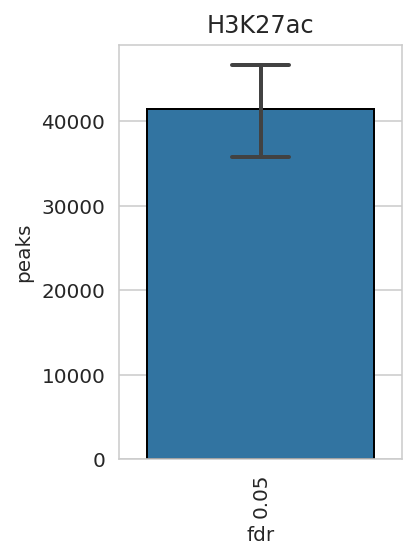

Average length


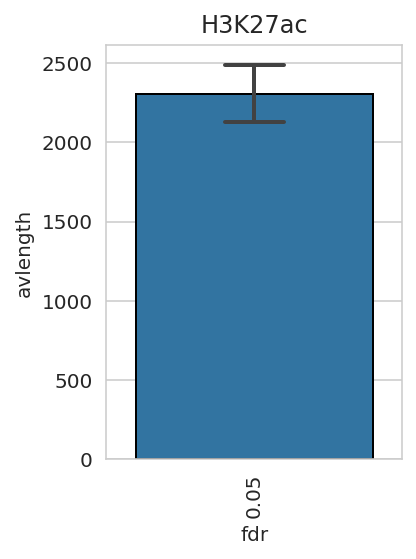

In [12]:
print('Peaks')
plotdf(df_fdr_span, 'span', 'peaks')

print('Average length')
plotdf(df_fdr_span, 'span', 'avlength')

### MACS narrow

In [13]:
# MACS2_FDRS = ['0.1', '0.01', '0.05', '1e-3', '1-e4', '1e-6', '1e-8', '1e-10']
MACS2_FDRS = ['0.05']
df_fdr_macs2 = load_peaks_fdr(os.path.join(GSE26320_PATH, 'macs2'), '.narrowPeak', MACS2_FDRS)
df_fdr_macs2['tool'] = 'MACS2'
df_fdr_macs2['dir'] = 'macs2'

  0%|          | 0/1280 [00:00<?, ?it/s]

Peaks


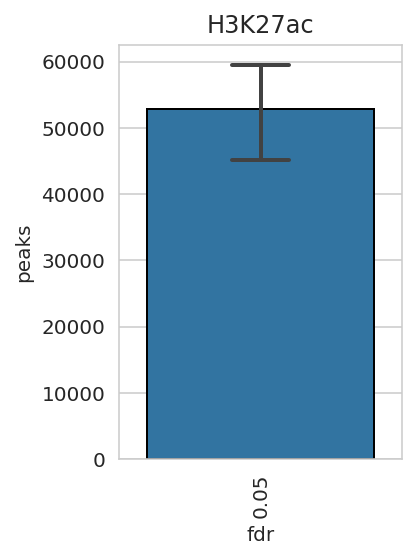

Average length


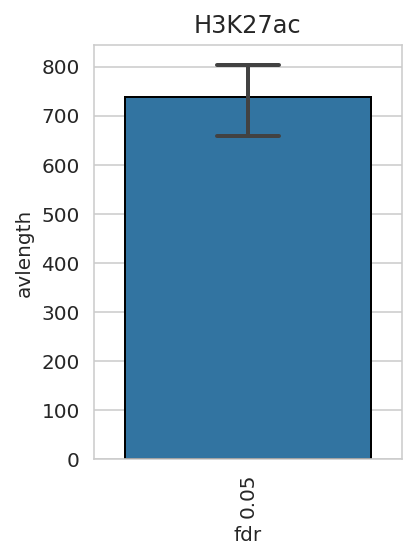

In [14]:
print('Peaks')
plotdf(df_fdr_macs2, 'macs2', 'peaks')

print('Average length')
plotdf(df_fdr_macs2, 'macs2', 'avlength')

### MACS2 broad

In [15]:
# MACS2BROAD_FDRS = ['0.1', '0.05', '1e-2', '1e-3', '1e-4', '1e-6', '1e-8', '1e-10']
MACS2BROAD_FDRS = ['0.1']
df_fdr_macs2broad = load_peaks_fdr(os.path.join(GSE26320_PATH, 'macs2'), '.broadPeak', MACS2BROAD_FDRS)
df_fdr_macs2broad['tool'] = 'MACS2 broad'
df_fdr_macs2broad['dir'] = 'macs2'

  0%|          | 0/1280 [00:00<?, ?it/s]

Peaks


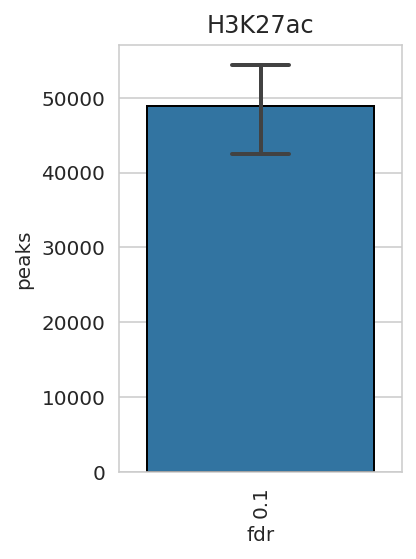

Average length


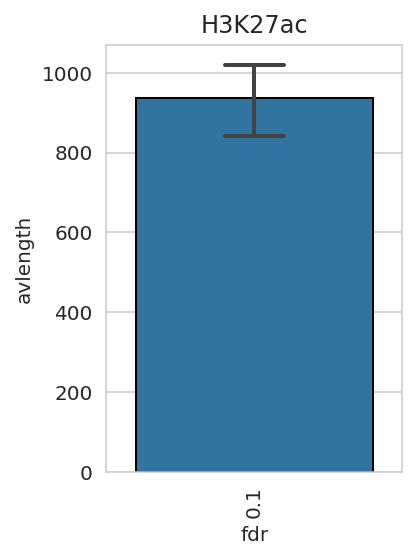

In [16]:
print('Peaks')
plotdf(df_fdr_macs2broad, 'macs2broad', 'peaks')

print('Average length')
plotdf(df_fdr_macs2broad, 'macs2broad', 'avlength')

### SICER

In [17]:
# SICER_FDRS = ['0.1', '0.05', '0.01', '0.001', '0.0001', '1e-06', '1e-08', '1e-10']
SICER_FDRS = ['0.01']
df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH, 'sicer'), 'summary-FDR', SICER_FDRS)
df_fdr_sicer['tool'] = 'SICER'
df_fdr_sicer['dir'] = 'sicer'

  0%|          | 0/1458 [00:00<?, ?it/s]

Peaks


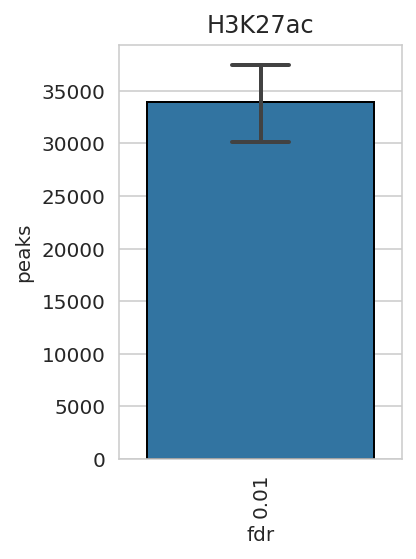

Average length


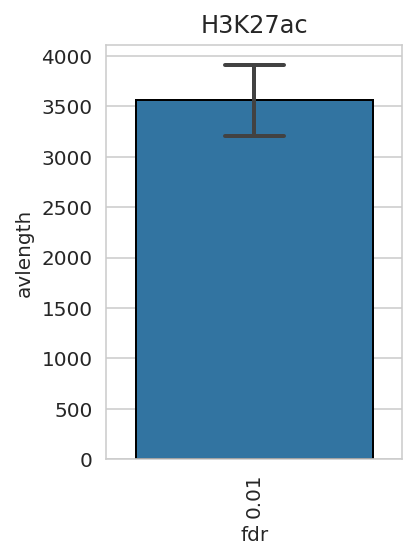

In [18]:
print('Peaks')
plotdf(df_fdr_sicer, 'sicer', 'peaks')

print('Average length')
plotdf(df_fdr_sicer, 'sicer', 'avlength')

## All peaks

In [19]:
df_fdr_peaks = pd.concat([df_fdr_span, df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer]).reset_index(drop=True)
df_fdr_peaks

,file,modification,cell,replicate,fdr,peaks,avlength,tool,dir
0,GSM646374_HMEC_H3K27ac_rep1_200_q0.05.peak,H3K27ac,HMEC,rep1,0.05,54286,2213.180525,SPAN,span
1,GSM646316_GM12878_H3K27ac_rep1_200_q0.05.peak,H3K27ac,GM12878,rep1,0.05,47555,2482.304532,SPAN,span
2,GSM646477_NHLF_H3K27ac_rep2_200_q0.05.peak,H3K27ac,NHLF,rep2,0.05,46805,2033.584403,SPAN,span
3,GSM646476_NHLF_H3K27ac_rep1_200_q0.05.peak,H3K27ac,NHLF,rep1,0.05,43527,2563.525283,SPAN,span
4,GSM646394_HSMM_H3K27ac_rep1_200_q0.05.peak,H3K27ac,HSMM,rep1,0.05,52110,1716.712646,SPAN,span
5,GSM646456_NHEK_H3K27ac_rep1_200_q0.05.peak,H3K27ac,NHEK,rep1,0.05,55588,2175.440815,SPAN,span
6,GSM646434_K562_H3K27ac_rep1_200_q0.05.peak,H3K27ac,K562,rep1,0.05,32532,2461.291651,SPAN,span
7,GSM646336_H1_H3K27ac_rep1_200_q0.05.peak,H3K27ac,H1,rep1,0.05,28272,2123.204761,SPAN,span
8,GSM646395_HSMM_H3K27ac_rep2_200_q0.05.peak,H3K27ac,HSMM,rep2,0.05,56307,1850.231872,SPAN,span
9,GSM646435_K562_H3K27ac_rep2_200_q0.05.peak,H3K27ac,K562,rep2,0.05,29078,2433.294725,SPAN,span


# Consistency analysis between replicates

In [20]:
reps_overlap = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2',
                                     'peaks1', 'peaks2', 'overlap', 'peaks1_overlap', 'peaks2_overlap'], dtype=object)

tools = list(sorted(set(df_fdr_peaks['tool'])))
for c, m in tqdm(product(GSE26320_CELLS, GSE26320_MODIFICATIONS)):
    print(c, m)
    tm = df_fdr_peaks[(df_fdr_peaks['cell'] == c) & (df_fdr_peaks['modification'] == m)]
    reps = list(sorted(set(tm['replicate'])))
    for tool in tools:
        for i in range(len(reps)):
            for j in range(i + 1, len(reps)):
                rep1, rep2 = reps[i], reps[j]
                t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep1)]
                t2 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep2)]
                file1 = GSE26320_PATH + '/' + t1['dir'].values[0] + '/' + t1['file'].values[0]
                file2 = GSE26320_PATH + '/' + t2['dir'].values[0] + '/' + t2['file'].values[0]
                peaks1 = t1['peaks'].values[0]
                peaks2 = t2['peaks'].values[0]
                length1 = bedl(file1).sum()
                length2 = bedl(file2).sum()

                for overlap, overlap_param in [
                    ('1bp overlap', ''),
                    ('50% overlap', ' -f 0.5 '),
                    ('80% overlap', ' -f 0.8 ')
                ]:
                    overlap1 = !bedtools intersect -a {file1} -b {file2} -wa -u {overlap_param} | wc -l
                    overlap1 = int(overlap1[0])
                    overlap2 = !bedtools intersect -b {file1} -a {file2} -wa -u {overlap_param} | wc -l
                    overlap2 = int(overlap2[0])

                    reps_overlap.loc[len(reps_overlap)] = \
                        (m, c, tool, rep1, rep2, peaks1, peaks2, overlap, overlap1, overlap2)

reps_overlap['peak1_overlap_fraction'] = [d(x, y) for x, y in zip(reps_overlap['peaks1_overlap'], reps_overlap['peaks1'])]
reps_overlap['peak2_overlap_fraction'] = [d(x, y) for x, y in zip(reps_overlap['peaks2_overlap'], reps_overlap['peaks2'])]
reps_overlap

0it [00:00, ?it/s]

GM12878 H3K27ac
HMEC H3K27ac
HSMM H3K27ac
K562 H3K27ac
NHEK H3K27ac
NHLF H3K27ac
H1 H3K27ac
HepG2 H3K27ac


,modification,cell,tool,rep1,rep2,peaks1,peaks2,overlap,peaks1_overlap,peaks2_overlap,peak1_overlap_fraction,peak2_overlap_fraction
0,H3K27ac,GM12878,MACS2,rep1,rep2,56001,50205,1bp overlap,38714,41817,0.691309,0.832925
1,H3K27ac,GM12878,MACS2,rep1,rep2,56001,50205,50% overlap,31305,37469,0.559008,0.746320
2,H3K27ac,GM12878,MACS2,rep1,rep2,56001,50205,80% overlap,19632,28503,0.350565,0.567732
3,H3K27ac,GM12878,MACS2 broad,rep1,rep2,50599,44989,1bp overlap,34936,37891,0.690448,0.842228
4,H3K27ac,GM12878,MACS2 broad,rep1,rep2,50599,44989,50% overlap,28270,34180,0.558707,0.759741
...,...,...,...,...,...,...,...,...,...,...,...,...
79,H3K27ac,HepG2,SICER,rep1,rep2,25590,26329,50% overlap,18332,22758,0.716374,0.864370
80,H3K27ac,HepG2,SICER,rep1,rep2,25590,26329,80% overlap,9525,18880,0.372216,0.717080
81,H3K27ac,HepG2,SPAN,rep1,rep2,30816,27576,1bp overlap,24230,24603,0.786280,0.892189
82,H3K27ac,HepG2,SPAN,rep1,rep2,30816,27576,50% overlap,20998,22908,0.681399,0.830722


In [21]:
t = pd.concat([
    reps_overlap[
        ['modification', 'cell', 'tool', 'peak1_overlap_fraction', 'overlap']
    ].copy().rename(dict(peak1_overlap_fraction='value'), axis=1),
    reps_overlap[
        ['modification', 'cell', 'tool', 'peak2_overlap_fraction', 'overlap']
    ].copy().rename(dict(peak2_overlap_fraction='value'), axis=1)
]).reset_index(drop=True)
t

,modification,cell,tool,value,overlap
0,H3K27ac,GM12878,MACS2,0.691309,1bp overlap
1,H3K27ac,GM12878,MACS2,0.559008,50% overlap
2,H3K27ac,GM12878,MACS2,0.350565,80% overlap
3,H3K27ac,GM12878,MACS2 broad,0.690448,1bp overlap
4,H3K27ac,GM12878,MACS2 broad,0.558707,50% overlap
...,...,...,...,...,...
163,H3K27ac,HepG2,SICER,0.864370,50% overlap
164,H3K27ac,HepG2,SICER,0.717080,80% overlap
165,H3K27ac,HepG2,SPAN,0.892189,1bp overlap
166,H3K27ac,HepG2,SPAN,0.830722,50% overlap


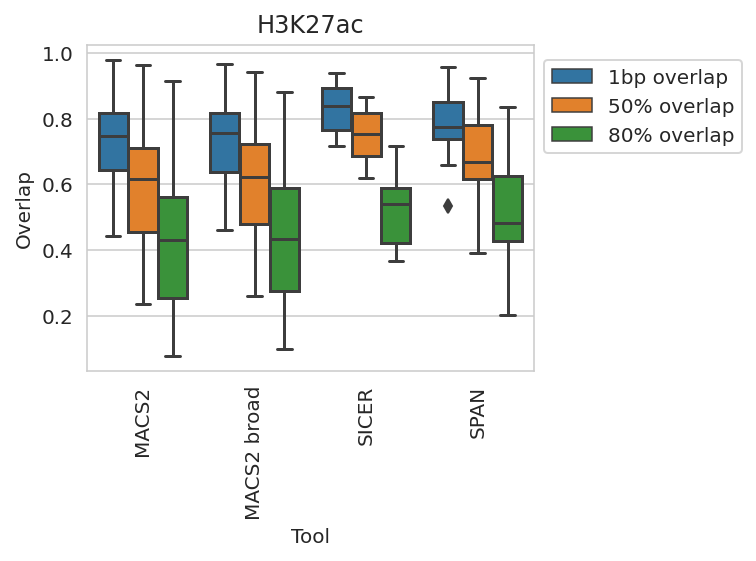

In [22]:
plt.figure(figsize=(len(GSE26320_MODIFICATIONS) * 4, 3))
for k, m in enumerate(GSE26320_MODIFICATIONS):
    ax = plt.subplot(1, len(GSE26320_MODIFICATIONS), k + 1)
    sns.boxplot(data=t[t['modification'] == m], x='tool', y='value', hue='overlap', ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(m)
    ax.set_xlabel('Tool')
    if k == 0:
        ax.set_ylabel('Overlap')
    else:
        ax.set_ylabel(None)
    if k == len(GSE26320_MODIFICATIONS) - 1:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.81))
    else:
        ax.get_legend().remove()
plt.savefig(f'{GSE26320_PATH}/analyze/overlap.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Coverage analysis

In [23]:
print('Load coverages files')
FILES = os.listdir(os.path.join(GSE26320_PATH, 'analyze/covs'))

reps = []
TOOLS = []
cells = []
mods = []
files = []

for f in FILES:
    rep, tool, cell, mod = None, None, None, None
    rep = 'rep1' if 'rep1' in f else 'rep2'

    if '.peak' in f:
        tool = 'SPAN'
    elif '-FDR' in f:
        tool = 'SICER'
    elif 'narrowPeak' in f:
        tool = 'MACS2'
    elif 'broadPeak' in f:
        tool = 'MACS2 broad'

    cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
    mod = next((m for m in GSE26320_MODIFICATIONS if m in f), None)

    if rep and tool and cell and mod:
        reps.append(rep)
        TOOLS.append(tool)
        cells.append(cell)
        mods.append(mod)
        files.append(f'{GSE26320_PATH}/analyze/covs/{f}')

df = pd.DataFrame(dict(cell=cells, modification=mods, rep=reps, file=files, tool=TOOLS))
df.groupby(['modification', 'tool']).count()

Load coverages files


cell  rep  file
modification tool                        
H3K27ac      MACS2          15   15    15
             MACS2 broad    15   15    15
             SICER          15   15    15
             SPAN           15   15    15

In [24]:
peaks = []
lengths = []
avlengths = []

for f in df['file']:
    ps, ls = lines(f), bedl(f)
    avls = 0 if ps == 0 else sum(ls) / ps
    peaks.append(ps)
    lengths.append(sum(ls))
    avlengths.append(avls)

df['peaks'] = peaks
df['length'] = lengths
df['average length'] = avlengths
df.head()

,cell,modification,rep,file,tool,peaks,length,average length
0,HMEC,H3K27ac,rep1,/home/jetbrains/data/GSE26320_RAW/analyze/covs...,SPAN,53048,117243246,2210.135085
1,GM12878,H3K27ac,rep2,/home/jetbrains/data/GSE26320_RAW/analyze/covs...,SPAN,35272,92651714,2626.778011
2,NHEK,H3K27ac,rep2,/home/jetbrains/data/GSE26320_RAW/analyze/covs...,SPAN,48417,98273839,2029.738294
3,K562,H3K27ac,rep1,/home/jetbrains/data/GSE26320_RAW/analyze/covs...,SICER,29279,112771121,3851.604256
4,GM12878,H3K27ac,rep1,/home/jetbrains/data/GSE26320_RAW/analyze/covs...,MACS2 broad,49411,55558730,1124.420271


## Load libraries tags coverage

In [25]:
coverage_df = pd.DataFrame(columns=['cell', 'replicate', 'modification', 'tags'], dtype=object)
for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    # print(c, r)
    sf = next((f for f in os.listdir(f'{GSE26320_PATH}/analyze/tags/') if f'{c}_WCE_{r}' in f), None)
    if sf:
        cc = lines(f'{GSE26320_PATH}/analyze/tags/' + sf)
        coverage_df.loc[len(coverage_df)] = (c, r, 'Input', cc)
    for m in GSE26320_MODIFICATIONS:
        # print(c, r, m)
        sf = next((f for f in os.listdir(f'{GSE26320_PATH}/analyze/tags/') if f'{c}_{m}_{r}' in f), None)
        if sf:
            ct = lines(f'{GSE26320_PATH}/analyze/tags/' + sf)
            coverage_df.loc[len(coverage_df)] = (c, r, m, ct)


def libcoverage_t(m, c, r):
    t = coverage_df[(coverage_df['modification'] == m) &
                    (coverage_df['cell'] == c) &
                    (coverage_df['replicate'] == r)]
    if len(t) == 0:
        return 0
    return t['tags'].values[0]

def libcoverage_c(c, r):
    return libcoverage_t('Input', c, r)

0it [00:00, ?it/s]

In [26]:
coverage_df

,cell,replicate,modification,tags
0,GM12878,rep1,Input,8091155
1,GM12878,rep1,H3K27ac,11832085
2,GM12878,rep2,Input,7377065
3,GM12878,rep2,H3K27ac,7443857
4,HMEC,rep1,Input,6870102
5,HMEC,rep1,H3K27ac,13342487
6,HMEC,rep2,Input,14849739
7,HMEC,rep2,H3K27ac,9499377
8,HSMM,rep1,Input,13244306
9,HSMM,rep1,H3K27ac,13284162


Libraries tags x10mln


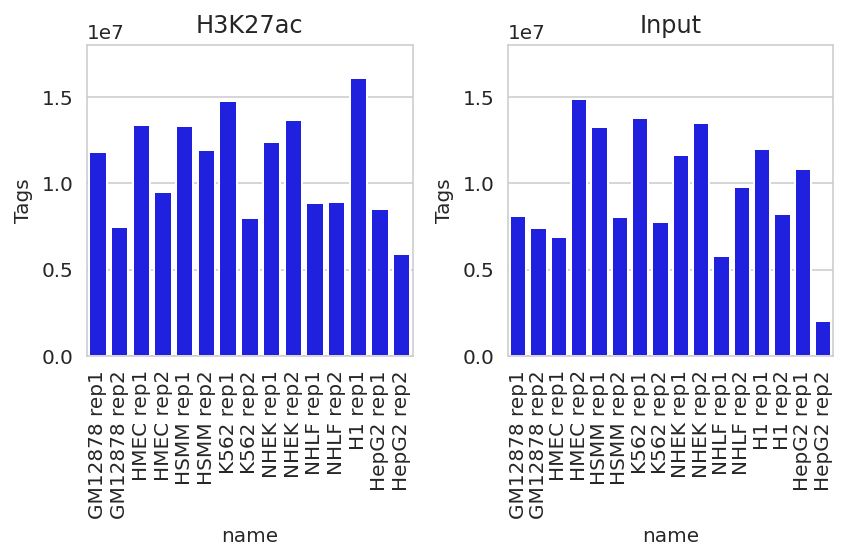

In [27]:
print('Libraries tags x10mln')
fig = plt.figure(figsize=(3 * (len(GSE26320_MODIFICATIONS) + 1), 4))
for i, m in enumerate(GSE26320_MODIFICATIONS + ['Input']):
    t = coverage_df.loc[coverage_df['modification'] == m].copy()
    t['name'] = t['cell'] + ' ' + t['replicate']
    ax = plt.subplot(1, len(GSE26320_MODIFICATIONS) + 1, i + 1)
    ax.title.set_text(m)
    sns.barplot(data=t, x='name', y='tags', ax=ax, color='blue')
    ax.set_ylim(bottom = 0, top = 1.8e7)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Tags')

plt.tight_layout()
plt.savefig(f'{GSE26320_PATH}/analyze/libraries.png', bbox_inches='tight', dpi=300)
plt.show()

# Loading detailed peaks information

In [28]:
def scores(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[4]
    except:
        return np.zeros(0) # Empty file

def positions(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[0] + ":" + tf[1].astype(str) + "-" + tf[2].astype(str)
    except:
        return [] # Empty file


def coverage_t(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[4]
    except:
        return [] # Empty file

def coverage_c(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[5]
    except:
        return [] # Empty file

In [29]:
df

,cell,modification,rep,file,tool,peaks,length,average length
0,HMEC,H3K27ac,rep1,/home/jetbrains/data/GSE26320_RAW/analyze/covs...,SPAN,53048,117243246,2210.135085
1,GM12878,H3K27ac,rep2,/home/jetbrains/data/GSE26320_RAW/analyze/covs...,SPAN,35272,92651714,2626.778011
2,NHEK,H3K27ac,rep2,/home/jetbrains/data/GSE26320_RAW/analyze/covs...,SPAN,48417,98273839,2029.738294
3,K562,H3K27ac,rep1,/home/jetbrains/data/GSE26320_RAW/analyze/covs...,SICER,29279,112771121,3851.604256
4,GM12878,H3K27ac,rep1,/home/jetbrains/data/GSE26320_RAW/analyze/covs...,MACS2 broad,49411,55558730,1124.420271
5,HepG2,H3K27ac,rep1,/home/jetbrains/data/GSE26320_RAW/analyze/covs...,MACS2,50245,42932828,854.469659
6,K562,H3K27ac,rep2,/home/jetbrains/data/GSE26320_RAW/analyze/covs...,SPAN,27884,67368790,2416.037513
7,NHEK,H3K27ac,rep1,/home/jetbrains/data/GSE26320_RAW/analyze/covs...,MACS2,70172,67482126,961.667417
8,NHEK,H3K27ac,rep2,/home/jetbrains/data/GSE26320_RAW/analyze/covs...,MACS2,65067,46399585,713.104723
9,NHLF,H3K27ac,rep2,/home/jetbrains/data/GSE26320_RAW/analyze/covs...,SPAN,45650,92910571,2035.280854


In [30]:
print('Processing peaks files')
! mkdir {GSE26320_PATH}/analyze/bed

TOOLS = list(sorted(set(df['tool'])))

peaks_info = []
for m, c, r in tqdm(product(GSE26320_MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)):
    print(m, c, r)

    # Processing single tools information
    for tool in TOOLS:
        t = df.loc[(df['cell'] == c) & (df['modification'] == m) & (df['rep'].str.contains(r)) & (df['tool']==tool)]
        if len(t) > 0:
            file = t['file'].values[0]
            peaks_info.extend((m, c, r, tool, 'tool', p, s, l, ct, cc)
                              for p, s, l, ct, cc in zip(positions(file), scores(file), bedl(file), coverage_t(file), coverage_c
                                  (file)))

    # Processing SPAN vs others
    for tool in TOOLS:
        if tool == 'SPAN':
            continue

        t_s = df.loc[
            (df['cell'] == c) & (df['modification'] == m) & (df['rep'].str.contains(r)) & (df['tool'] == 'SPAN')]
        t_o = df.loc[(df['cell'] == c) & (df['modification'] == m) & (df['rep'].str.contains(r)) & (df['tool'] == tool)]
        if len(t_s) == 0 or len(t_o) == 0:
            continue
        file_span, file_other = t_s['file'].values[0], t_o['file'].values[0]

        # Overlap span_vs_other
        tf = f'{GSE26320_PATH}/analyze/bed/{m}_{c}_{r}_overlap_SPAN_vs_{tool}.bed'.replace(' ', '_')
        !bedtools intersect -a {file_span} -b {file_other} -wa -u > {tf}
        peaks_info.extend((m, c, r, tool, 'overlap_span_vs_other', p, s, l, ct, cc)
                          for p, s, l, ct, cc in zip(positions(tf), scores(tf), bedl(tf), coverage_t(tf), coverage_c(tf)))

        # Overlap other_vs_span
        tf = f'{GSE26320_PATH}/analyze/bed/{m}_{c}_{r}_overlap_{tool}_vs_SPAN.bed'.replace(' ', '_')
        !bedtools intersect -b {file_span} -a {file_other} -wa -u > {tf}
        peaks_info.extend((m, c, r, tool, 'overlap_other_vs_span', p, s, l, ct, cc)
                          for p, s, l, ct, cc in zip(positions(tf), scores(tf), bedl(tf), coverage_t(tf), coverage_c(tf)))

        # Diff span_vs_other
        tf = f'{GSE26320_PATH}/analyze/bed/{m}_{c}_{r}_diff_SPAN_vs_{tool}.bed'.replace(' ', '_')
        !bedtools intersect -a {file_span} -b {file_other} -v > {tf}
        peaks_info.extend((m, c, r, tool, 'diff_span_vs_other', p, s, l, ct, cc)
                          for p, s, l, ct, cc in zip(positions(tf), scores(tf), bedl(tf), coverage_t(tf), coverage_c(tf)))

        # Diff other_vs_span
        tf = f'{GSE26320_PATH}/analyze/bed/{m}_{c}_{r}_diff_{tool}_vs_SPAN.bed'.replace(' ', '_')
        !bedtools intersect -b {file_span} -a {file_other} -v > {tf}
        peaks_info.extend((m, c, r, tool, 'diff_other_vs_span', p, s, l, ct, cc)
                          for p, s, l, ct, cc in zip(positions(tf), scores(tf), bedl(tf), coverage_t(tf), coverage_c(tf)))
df_peaks = pd.DataFrame(peaks_info, columns=[
    'modification', 'cell', 'replicate', 'tool', 'type', 'position', 'score', 'length', 'coveraget', 'coveragec'
])
del peaks_info
display(df_peaks.head())

Processing peaks files


0it [00:00, ?it/s]

H3K27ac GM12878 rep1
H3K27ac GM12878 rep2
H3K27ac HMEC rep1
H3K27ac HMEC rep2
H3K27ac HSMM rep1
H3K27ac HSMM rep2
H3K27ac K562 rep1
H3K27ac K562 rep2
H3K27ac NHEK rep1
H3K27ac NHEK rep2
H3K27ac NHLF rep1
H3K27ac NHLF rep2
H3K27ac H1 rep1
H3K27ac H1 rep2
H3K27ac HepG2 rep1
H3K27ac HepG2 rep2


,modification,cell,replicate,tool,type,position,score,length,coveraget,coveragec
0,H3K27ac,GM12878,rep1,MACS2,tool,chr1:751842-752860,154,1018,154,5
1,H3K27ac,GM12878,rep1,MACS2,tool,chr1:752902-753255,23,353,23,1
2,H3K27ac,GM12878,rep1,MACS2,tool,chr1:865523-865757,18,234,18,0
3,H3K27ac,GM12878,rep1,MACS2,tool,chr1:883825-884461,31,636,31,0
4,H3K27ac,GM12878,rep1,MACS2,tool,chr1:917928-918183,10,255,10,1


In [31]:
print('Compute RPM and RPKM for peaks')
for m, c, r in tqdm(product(GSE26320_MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)):
    print(m, c, r)
    lct = libcoverage_t(m, c, r) * 1e-6
    lcc = libcoverage_c(c, r) * 1e-6
    t = df_peaks.loc[(df_peaks['modification'] == m) & (df_peaks['cell']==c) & (df_peaks['replicate']==r)].copy()
    t['rpmt'] = t['coveraget'] / lct
    t['rpmc'] = t['coveragec'] / lcc
    t['rpkmt'] = t['rpmt'] / t['length'] * 1e3
    t['rpkmc'] = t['rpmc'] / t['length'] * 1e3
    for col in ['rpmt', 'rpmc', 'rpkmt', 'rpkmc']:
        df_peaks.loc[(df_peaks['modification'] == m) & (df_peaks['cell']==c) & (df_peaks['replicate']==r), col] = list(t[col])
    del t

Compute RPM and RPKM for peaks


0it [00:00, ?it/s]

H3K27ac GM12878 rep1
H3K27ac GM12878 rep2
H3K27ac HMEC rep1
H3K27ac HMEC rep2
H3K27ac HSMM rep1
H3K27ac HSMM rep2
H3K27ac K562 rep1
H3K27ac K562 rep2
H3K27ac NHEK rep1
H3K27ac NHEK rep2
H3K27ac NHLF rep1
H3K27ac NHLF rep2
H3K27ac H1 rep1
H3K27ac H1 rep2
H3K27ac HepG2 rep1
H3K27ac HepG2 rep2


## Aggregated for all tools

In [32]:
PLOT_TYPES = ['peaks', 'length', 'rpm', 'rpkm']
TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'SPAN']

def process_type(df_peaks, m, peaks_type, tool, plot_type, name, show_control=False):
    t = df_peaks[(df_peaks['modification'] == m) & (df_peaks['type']==peaks_type) & (df_peaks['tool']==tool)]
    if len(t) == 0:
        return pd.DataFrame(columns=['cell', 'replicate', 'value', 'variable'], dtype=object)
    if plot_type == 'peaks':
        t = t.groupby(['cell', 'replicate']).size().reset_index(name='value')[['value']].copy()
    elif plot_type in ['score', 'length']:
        t = t[['cell', 'replicate', plot_type]].copy()
        t.rename({plot_type: 'value'}, axis=1, inplace=True)
    elif plot_type in ['rpm', 'rpkm']:
        ts = []
        tt = t[['cell', 'replicate', plot_type + 't']].copy()
        tt.rename({plot_type + 't': 'value'}, axis=1, inplace=True)
        tt['type'] = 'treatment'
        ts.append(tt)
        if show_control:
            tt = t[['cell', 'replicate', plot_type + 'c']].copy()
            tt.rename({plot_type + 'c': 'value'}, axis=1, inplace=True)
            tt['type'] = 'control'
            ts.append(tt)
        t = pd.concat(ts).reset_index(drop=True)
    t['variable'] = name
    return t

def plot_tools_summary_type(df_peaks, title, plot_type=PLOT_TYPES[0], tools=TOOLS,
                            show_tool=True, show_overlap=True, show_diff=True,
                            show_control=True, use_bar=False,
                            extend_plot_function=None,
                            ymin=None, ymax=None, ext='png'):
    if plot_type not in PLOT_TYPES:
        raise Exception(f'Unknown plot type {plot_type}, expected one of {PLOT_TYPES}')
    width = (
                    (1 if show_tool else 0) +
                    (1 if show_overlap else 0) +
                    (1 if show_diff else 0)
            ) * (1.5 if show_control else 1)
    plt.figure(figsize=(width * len(GSE26320_MODIFICATIONS) * 2, 5))

    for k, m in enumerate(GSE26320_MODIFICATIONS):
        tts = []
        # print(m)

        # Processing tool
        if show_tool:
            for tool in tools:
                tts.append(process_type(df_peaks, m, 'tool', tool, plot_type, tool, show_control))

        # Overlap processing
        if show_overlap:
            if 'SPAN' not in tools:
                continue  # Cannot show overlap without SPAN
            for tool in tools:
                if tool != 'SPAN':
                    tts.append(process_type(df_peaks, m, 'overlap_span_vs_other', tool, plot_type, f'SPAN ∩ {tool}', show_control))
            for tool in tools:
                if tool != 'SPAN':
                    tts.append(process_type(df_peaks, m, 'overlap_other_vs_span', tool, plot_type, f'{tool} ∩ SPAN', show_control))

        # Difference processing
        if show_diff:
            if 'SPAN' not in tools:
                continue  # Cannot show overlap without SPAN
            for tool in tools:
                if tool != 'SPAN':
                    tts.append(process_type(df_peaks, m, 'diff_span_vs_other', tool, plot_type, f'SPAN - {tool}', show_control))
            for tool in tools:
                if tool != 'SPAN':
                    tts.append(process_type(df_peaks, m, 'diff_other_vs_span', tool, plot_type, f'{tool} - SPAN', show_control))

        t = pd.concat(tts).reset_index(drop=True)
        t['value'] = t['value'].astype(float)

        # Process variables
        for var in set(t['variable']):
            if sum(t['variable'] == var) == 0:
                continue
            # Add mean variables
            tm = t[t['variable'] == var]['value'].mean()
            if plot_type in ['peaks', 'length']:
                t.loc[t['variable'] == var, 'variable'] = f'{var} ({int(tm)})'
            else:
                t.loc[t['variable'] == var, 'variable'] = f'{var} ({tm:.3f})'

        # Allow to append additional data to plot
        if extend_plot_function is not None:
            t = extend_plot_function(m, t)

        # Plot
        ax = plt.subplot(1, len(GSE26320_MODIFICATIONS), k + 1)
        ax.title.set_text(m)
        if plot_type in ['rpm', 'rpkm']:
            if use_bar:
                g_results = sns.barplot(data=t, x='variable', y='value', hue='type', capsize=.2, errwidth=2, ax=ax)
            else:
                g_results = sns.boxplot(data=t, x='variable', y='value', hue='type', ax=ax)
        else:
            if use_bar:
                g_results = sns.barplot(data=t, x='variable', y='value', capsize=.2, errwidth=2, ax=ax)
            else:
                g_results = sns.boxplot(data=t, x='variable', y='value', ax=ax)

        if plot_type == 'length':
            g_results.set(yscale='log')

        ax.xaxis.set_tick_params(rotation=90)
        ax.set_ylabel(title)
        if k > 0:
            ax.set_ylabel(None)
        if ymin is not None:
            ax.set_ylim(bottom=ymin)
        if ymax is not None:
            ax.set_ylim(top=ymax)

        if plot_type == 'rpm' or plot_type == 'rpkm':
            if k == len(GSE26320_MODIFICATIONS) - 1:
                # Put a legend to the right of the current axis
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.81))
            else:
                ax.get_legend().remove()

    plt.tight_layout()
    plt.savefig(f'{GSE26320_PATH}/analyze/{plot_type}.{ext}', bbox_inches='tight', dpi=300)
    plt.show()

Peaks number


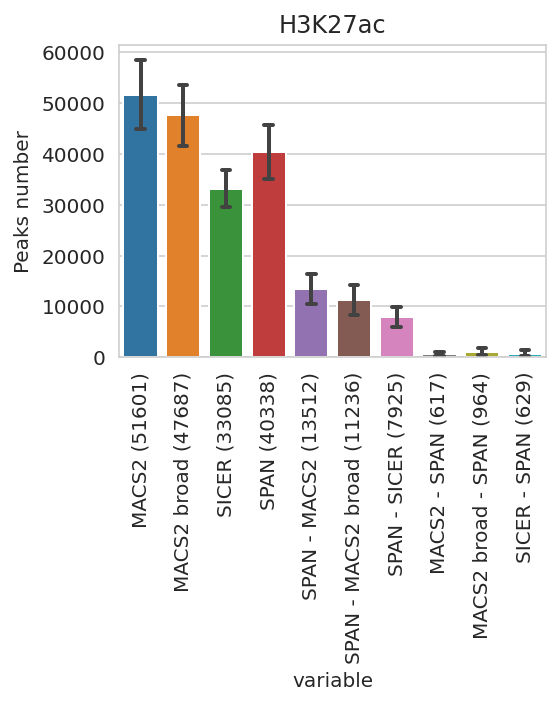

Peaks length


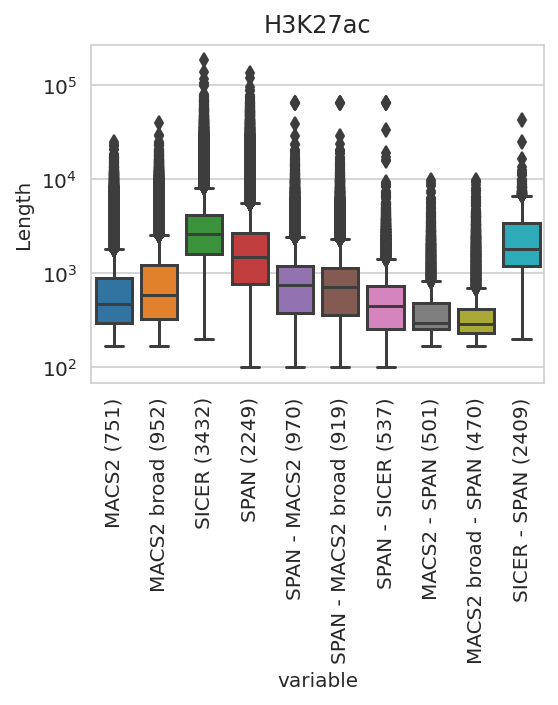

RPM


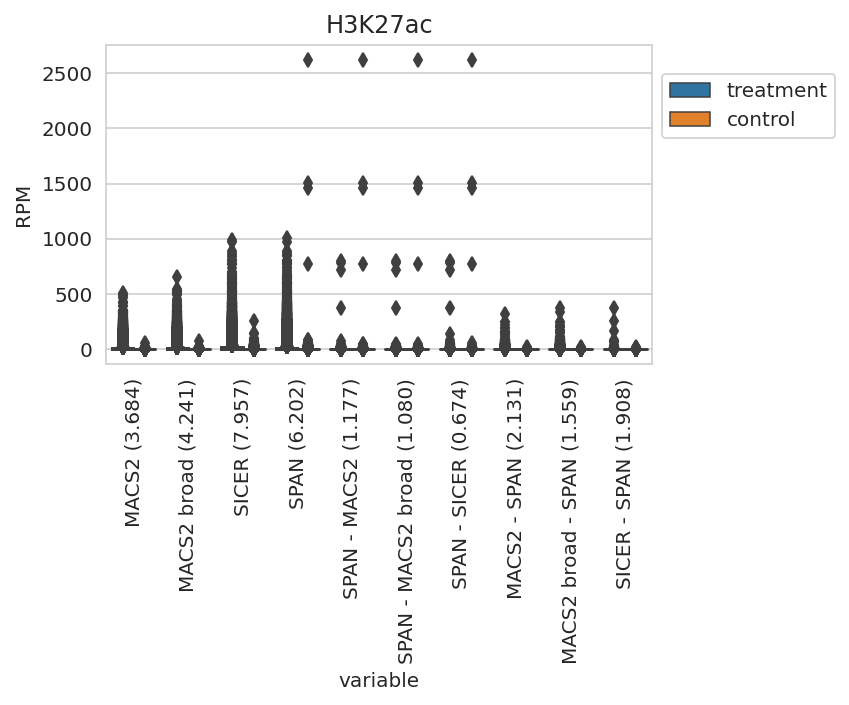

RPKM


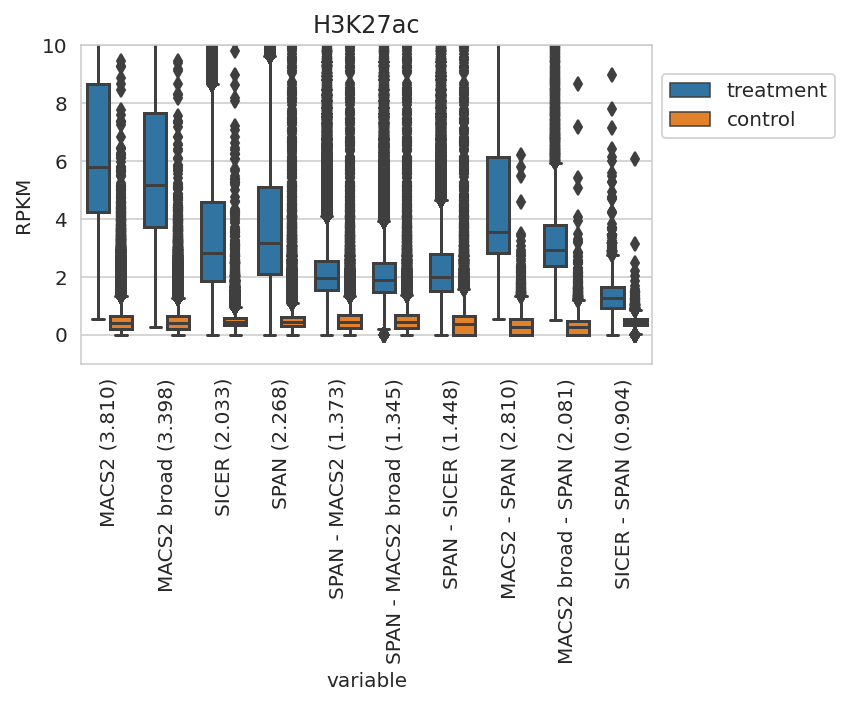

In [33]:
print('Peaks number')
plot_tools_summary_type(df_peaks, 'Peaks number', 'peaks',
                        show_tool=True, show_overlap=False, show_diff=True, show_control=False, use_bar=True,
                        ext='pdf')
print('Peaks length')
plot_tools_summary_type(df_peaks, 'Length', 'length',
                        show_tool=True, show_overlap=False, show_diff=True, show_control=False, use_bar=False,
                        ext='pdf')
print('RPM')
plot_tools_summary_type(df_peaks, 'RPM', 'rpm',
                        show_tool=True, show_overlap=False, show_diff=True, show_control=True, use_bar=False, ext='pdf')
print('RPKM')
plot_tools_summary_type(df_peaks, 'RPKM', 'rpkm',
                        show_tool=True, show_overlap=False, show_diff=True, show_control=True, use_bar=False,
                        ymin=-1, ymax=10,
                        ext='pdf')

In [64]:
__break__

NameError: name '__break__' is not defined

## Adding expressed genes lengths to plot

In [33]:
import re

print('Loading GTF genes markup')
GSE26320_PATH = os.path.expanduser('~/data/GSE26320_RAW')

GTF = 'gencode.v19.annotation.gtf.gz'
gtf_df = pd.read_csv(os.path.join(GSE26320_PATH, GTF), sep='\t', comment='#',
                     names=['chromosome', 'db', 'type', 'start', 'end', 'point1', 'strand', 'point2', 'aux'])
print('Loaded', len(gtf_df))

print('Parse GTF aux data')
auxes = {}
for i, aux in enumerate(tqdm(gtf_df['aux'])):
    for pair in aux.split(';'):
        kv = pair.strip().split(' ')
        if len(kv) != 2:
            continue
        k, v = kv
        if k not in auxes:
            auxes[k] = vs = []
        else:
            vs = auxes[k]
        vs.append(v.strip('"'))

for k, vs in auxes.items():
    if len(vs) == len(gtf_df):
        gtf_df[k] = vs
    else:
        print(f'Ignoring {k}')
del auxes
gtf_df.drop('aux', axis=1, inplace=True)

gtf_genes_df = gtf_df[gtf_df['type'] == 'gene'].copy()
print('GTF genes', len(gtf_genes_df))

# Fix . in gene_id
gtf_genes_df['gene_id'] = [re.sub('\..*', '', id) for id in gtf_genes_df['gene_id']]

Loading GTF genes markup
Loaded 2619444
Parse GTF aux data


  0%|          | 0/2619444 [00:00<?, ?it/s]

Ignoring havana_gene
Ignoring tag
Ignoring havana_transcript
Ignoring exon_number
Ignoring exon_id
Ignoring ont
Ignoring protein_id
Ignoring ccdsid
GTF genes 57820


In [34]:
PATH = os.path.expanduser('~/data/GSE26312_RAW')

expr_files = [f for f in sorted(os.listdir(PATH)) if f.endswith('.ann')]

TOP_GENES = 12000

thresholds = {}

expr_genes_length = []
expr_genes_cells = []
expr_genes_reps = []

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    if c == 'H1':  # Ignore H1, as expression is with different platform
        continue
    print(c, r)
    expr_file = [f for f in expr_files if c in f and r in f]
    if len(expr_file) == 0:
        continue
    file = expr_file[0]
    expr_df = pd.read_csv(PATH + '/' + file, sep='\t')
    expr_df['ensembl_gene_id'] = expr_df['ensembl_gene_id'].astype(str)
    expr_dfp = expr_df[expr_df['gene_biotype'] == 'protein_coding']
    threshold = list(expr_dfp['expression'].copy().sort_values(ascending=False))[TOP_GENES]
    print(file, f'threshold for {TOP_GENES} genes', threshold)
    thresholds[file] = threshold
    # Join on genes names
    high_expr_dfp = pd.merge(expr_dfp[expr_dfp['expression'] > threshold], gtf_genes_df,
                             left_on='ensembl_gene_id', right_on='gene_id')[
        ['chromosome', 'start', 'end', 'gene_id', 'strand', 'expression']
    ]
    high_expr_dfp.sort_values(by=['chromosome', 'start'], inplace=True)

    expr_genes_length.extend(high_expr_dfp['end'] - high_expr_dfp['start'])
    expr_genes_cells.extend([c] * len(high_expr_dfp))
    expr_genes_reps.extend([r] * len(high_expr_dfp))
expr_genes_df = pd.DataFrame(dict(cell=expr_genes_cells, replicate=expr_genes_reps, length=expr_genes_length))
expr_genes_df.sample(5)

0it [00:00, ?it/s]

GM12878 rep1
GSM646142_GM12878_rep1.txt.ann threshold for 12000 genes 16.3307363
GM12878 rep2
GSM646143_GM12878_rep2.txt.ann threshold for 12000 genes 16.31648265
HMEC rep1
GSM646146_HMEC_rep1.txt.ann threshold for 12000 genes 16.00979249
HMEC rep2
GSM646147_HMEC_rep2.txt.ann threshold for 12000 genes 15.70374021
HSMM rep1
GSM646148_HSMM_rep1.txt.ann threshold for 12000 genes 16.52760449
HSMM rep2
GSM646149_HSMM_rep2.txt.ann threshold for 12000 genes 16.54256007
K562 rep1
GSM646153_K562_rep1.txt.ann threshold for 12000 genes 15.98339127
K562 rep2
GSM646154_K562_rep2.txt.ann threshold for 12000 genes 15.75958007
NHEK rep1
GSM646155_NHEK_rep1.txt.ann threshold for 12000 genes 15.65157978
NHEK rep2
GSM646156_NHEK_rep2.txt.ann threshold for 12000 genes 16.31595586
NHLF rep1
GSM646157_NHLF_rep1.txt.ann threshold for 12000 genes 16.540006
NHLF rep2
GSM646158_NHLF_rep2.txt.ann threshold for 12000 genes 16.60197177
HepG2 rep1
GSM646144_HepG2_rep1.txt.ann threshold for 12000 genes 16.68130186
H

,cell,replicate,length
80023,K562,rep2,53847
21372,HMEC,rep1,8819
30526,HMEC,rep1,69892
92222,NHEK,rep1,431391
54246,HSMM,rep2,21242


Peaks length


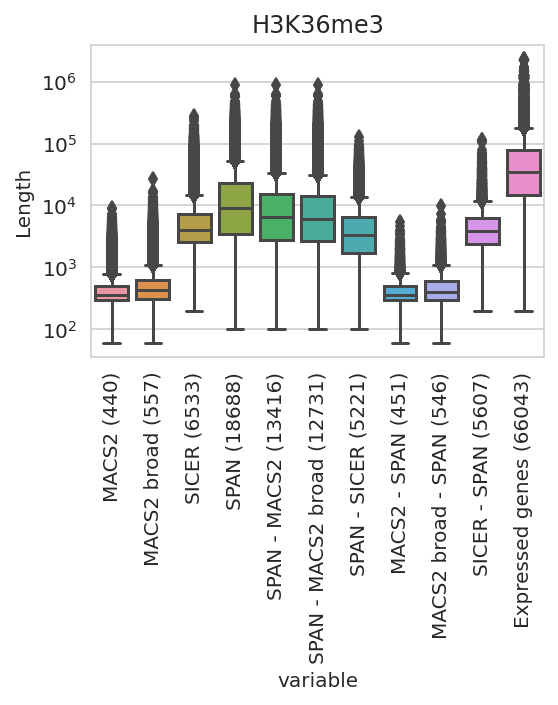

In [36]:
expr_genes_df.rename(dict(length='value'), axis=1, inplace=True)
expr_genes_df['variable'] = f'Expressed genes ({int(expr_genes_df["value"].mean())})'

def add_genes_length(m, t):
    return pd.concat([t, expr_genes_df])

print('Peaks length')
plot_tools_summary_type(df_peaks, 'Length', 'length',
                        show_tool=True, show_overlap=False, show_diff=True, show_control=False, use_bar=False,
                        extend_plot_function=add_genes_length,
                        ext='pdf')


# Peaks density vs length scatterplot

In [ ]:
N = 10_000
for m in GSE26320_MODIFICATIONS:
    print(m)
    plt.figure(figsize=(14, 4))
    k = 1
    t_span = df_peaks[(df_peaks['modification'] == m) & (df_peaks['type'] == 'tool') & (df_peaks['tool'] == 'SPAN')]
    t_span = t_span.sample(min(len(t_span), N))[['rpkmt', 'length', 'tool']].copy()
    for tool in tqdm(TOOLS):
        if tool == 'SPAN':
            continue
        # Use stratified sampling for performance reasons
        t = df_peaks[(df_peaks['modification'] == m) & (df_peaks['type'] == 'tool') & (df_peaks['tool'] == tool)]
        tst = pd.concat([t_span, t.sample(min(len(t), N))[['rpkmt', 'length', 'tool']].copy()])

        # Plot
        ax = plt.subplot(1, 3, k)
        k += 1
        # Clip for aesthetics
        sns.kdeplot(x=tst['length'].clip(upper=20000).values,
                    y=tst['rpkmt'].clip(upper=30.0).values,
                    hue=tst['tool'].values,
                    fill=True, alpha=0.4, ax=ax)
        ax.title.set_text(f'{m} SPAN vs {tool}')
        ax.set_xlabel('Length')
        ax.set_ylabel('RPKM')

    plt.tight_layout()
    plt.savefig(f'{GSE26320_PATH}/analyze/density_vs_len_{m}.pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Save most significant peaks from difference with SPAN

In [ ]:
BW_PATH = f'{GSE26320_PATH}/bw'
print('BW_PATH', BW_PATH)

BED4_PATH = f'{GSE26320_PATH}/analyze/bed4'
print('BED4_PATH', BED4_PATH)

JBR_PATH = f'{GSE26320_PATH}/jbr-1.0.5577.jar'
print('JBR_PATH', JBR_PATH)

BLACKLISTED = f'{GSE26320_PATH}/hg19-blacklist.v2.bed'

! mkdir {GSE26320_PATH}/analyze/diff
print('DIFF_PATH', f'{GSE26320_PATH}/analyze/diff')

def find_bw_file(m, c, r):
    return glob.glob(f'{BW_PATH}/*{c}_{m}_{r}*.bw')[0]

def find_bw_input_file(c, r):
    return glob.glob(f'{BW_PATH}/*{c}_WCE_{r}*.bw')[0]


def find_peaks_file(m, c, r, tool):
    if tool == 'SPAN':
        ext = '.peak'
    elif tool == 'MACS2':
        ext = '.narrowPeak'
    elif tool == 'MACS2 broad':
        ext = '.broadPeak'
    elif tool == 'SICER':
        ext = '-FDR0.01'
    else:
        raise f'Unexpected tool {tool}'
    files = glob.glob(f'{BED4_PATH}/*{c}_{m}_{r}*{ext}.bed4')
    if len(files) == 1:
        return files[0]
    return None

! mkdir -p {GSE26320_PATH}/analyze/diff

def save_span_diff_screenshots(df_peaks, tools=TOOLS, metrics='rpkmt', n=1):
    """ Save most significant differential peaks with SPAN"""
    if 'SPAN' not in tools:
        raise Exception('Cannot show overlap without SPAN')

    for m in tqdm(GSE26320_MODIFICATIONS):
        print(f'Processing {m}')

        # Difference processing
        for tool in tools:
            if tool != 'SPAN':
                print(tool)
                t = df_peaks[(df_peaks['modification'] == m) &
                             (df_peaks['type']=='diff_span_vs_other') &
                             (df_peaks['tool'] == tool)]

                t = t[[re.match('^chr[0-9]+:[0-9]+\\-[0-9]+$', p) is not None for p in t['position']]].copy()
                if len(t) == 0:
                    continue
                t = t.sort_values(by=[metrics], ascending=False).head(n).copy().reset_index()
                for i, row in t.iterrows():
                    c, r, p, mt = row['cell'], row['replicate'], row['position'], row[metrics]
                    bw_file = find_bw_file(m, c, r)
                    bw_input_file = find_bw_input_file(c, r)
                    span_peaks_file = find_peaks_file(m, c, r, 'SPAN')
                    tool_peaks_file = find_peaks_file(m, c, r, tool)
                    if bw_file is None or bw_input_file is None or span_peaks_file is None or tool_peaks_file is None:
                        continue
                    other_peaks = ''
                    for t in [t for t in tools if t != tool and t != 'SPAN']:
                        to = find_peaks_file(m, c, r, t)
                        if to is not None:
                            other_peaks += f',{to}'
                    screenshot = f'{metrics}_{m}_diff_span_vs_{tool}_{i}_{mt:.3f}_{c}_{r}_{p}'.replace(' ', '_').replace(':', '_').replace('-', '_')
                    ! java -jar {JBR_PATH} --screenshot {GSE26320_PATH}/analyze/diff/{screenshot}_1.png --genome hg19 --screenshot_tracks {bw_file},{bw_input_file},{span_peaks_file},{tool_peaks_file}{other_peaks},{BLACKLISTED} --screenshot_position {p} --screenshot_zoomout 30 --screenshot_scalegroup 1,2 --screenshot_retina
                    ! java -jar {JBR_PATH} --screenshot {GSE26320_PATH}/analyze/diff/{screenshot}_2.png --genome hg19 --screenshot_tracks {bw_file},{bw_input_file},{span_peaks_file},{tool_peaks_file}{other_peaks},{BLACKLISTED} --screenshot_position {p} --screenshot_zoomout 300 --screenshot_scalegroup 1,2 --screenshot_retina


In [ ]:
save_span_diff_screenshots(df_peaks, tools=TOOLS, metrics='rpkmt', n=2)

In [ ]:
save_span_diff_screenshots(df_peaks, tools=TOOLS, metrics='score', n=2)

In [ ]:
__break__

# Pairwise peaks number venn diagrams vs SPAN for each cell and replicate

In [ ]:
from matplotlib_venn import venn2, venn2_circles


def venn_overlap(ax, peaks1, peaks2, overlap12, overlap21):
    # Tweak subsets to avoid empty areas
    subsets = (max(0.15 * max(peaks1, peaks2), peaks1 - overlap12),
               max(0.15 * max(peaks1, peaks2), peaks2 - overlap21),
               max(0.3 * max(peaks1, peaks2), overlap12, overlap21))
    v = venn2(subsets=subsets, set_labels=('SPAN', tool), set_colors=('r', 'g'), alpha=0.5, ax=ax)
    venn2_circles(subsets=subsets, color='grey')
    v.get_label_by_id('10').set_text(str(peaks1 - overlap12))
    v.get_label_by_id('01').set_text(str(peaks2 - overlap21))
    if overlap12 != 0 and overlap21 != 0:
        prop = f'{overlap12 / overlap21:.1f} : 1' if overlap12 > overlap21 else f'1 : {overlap21 / overlap12:.1f}'
        prop = prop.replace('.0', '')  # Cosmetics
    else:
        prop = ''
    v.get_label_by_id('11').set_text(f'{overlap12} : {overlap21}\n{prop}')
    for text in v.set_labels:
        text.set_fontsize(7)
    for text in v.subset_labels:
        text.set_fontsize(5)


for m in GSE26320_MODIFICATIONS:
    print(m)
    plt.figure(figsize=(15 * len(GSE26320_CELLS), 15 * len(TOOLS) * (len(TOOLS) - 1)))
    k = 1
    for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
        t = df_peaks[(df_peaks['modification'] == m) & (df_peaks['cell'] == c) &(df_peaks['replicate'] == r)]
        for tool in TOOLS:
            if tool == 'SPAN':
                continue
            peaks1 = len(t[(t['type'] == 'tool') & (t['tool'] == 'SPAN')])
            peaks2 = len(t[(t['type'] == 'tool') & (t['tool'] == tool)])
            overlap12 = len(t[(t['type'] == 'overlap_span_vs_other') & (t['tool'] == tool)])
            overlap21 = len(t[(t['type'] == 'overlap_other_vs_span') & (t['tool'] == tool)])

            # Plot
            ax = plt.subplot(len(GSE26320_CELLS), len(TOOLS) * (len(TOOLS) - 1), k)
            k += 1

            venn_overlap(ax, peaks1, peaks2, overlap12, overlap21)
            ax.title.set_text(f'{m} {c} {r}')

    plt.tight_layout()
    plt.savefig(f'{GSE26320_PATH}/analyze/venn_{m}.png', bbox_inches='tight', dpi=300)
    plt.show()

# Peaks length and density distributions analysis

In [ ]:
PALETTE = {'MACS2': 'green', 'MACS2 broad': 'blue', 'SICER': 'orange', 'SPAN': 'brown'}
N = 100000

def plot_distribution(df_peaks, value, tools=TOOLS, threshold=None, log_scale_after_threshold=False):
    plt.figure(figsize=(16 if threshold is not None else 14, 6 if threshold is not None else 4))
    for i, m in enumerate(GSE26320_MODIFICATIONS):
        print(m)
        ts = df_peaks[(df_peaks['modification'] == m) & (df_peaks['type'] == 'tool')][[value, 'tool']].copy()

        # Use stratified sampling for performance reasons
        tss = []
        for tool in tools:
            tst = ts[ts['tool'] == tool]
            tss.append(tst.sample(min(len(tst), N)))
        tst = pd.concat(tss)

        # Plot
        if threshold is not None:
            ax = plt.subplot(2, len(GSE26320_MODIFICATIONS), i + 1)
            sns.histplot(data=tst.loc[tst[value] <= threshold], x=value, hue='tool', palette=PALETTE, element="poly", ax=ax)
            ax.title.set_text(m)
            if i > 0:
                ax.set_ylabel('')
            else:
                ax.set_ylabel(f'{value} <= {threshold}')

            ax = plt.subplot(2, len(GSE26320_MODIFICATIONS), i + 1 + len(GSE26320_MODIFICATIONS))
            sns.histplot(data=tst.loc[tst[value] > threshold], x=value, hue='tool', log_scale=log_scale_after_threshold, element="poly", palette=PALETTE, ax=ax)
            if i > 0:
                ax.set_ylabel('')
            else:
                ax.set_ylabel(f'{value} > {threshold}')
        else:
            ax = plt.subplot(2, len(GSE26320_MODIFICATIONS), i + 1)
            sns.histplot(data=tst, x=value, hue='tool', palette=PALETTE, element="poly", ax=ax)
            ax.title.set_text(m)
            if i > 0:
                ax.set_ylabel('')
            else:
                ax.set_ylabel(value)

            ax.title.set_text(m)
    plt.tight_layout()
    plt.savefig(f'{GSE26320_PATH}/analyze/hist_{value}_{"_".join(tools)}_{threshold}.png', bbox_inches='tight', dpi=300)
    plt.show()

In [ ]:
print('Length distribution with 10k separation without SPAN')
plot_distribution(df_peaks, 'length', tools=['MACS2', 'MACS2 broad', 'SICER'], threshold=10000, log_scale_after_threshold=True)

In [ ]:
print('RPKM distribution')
plot_distribution(df_peaks, 'rpkmt', tools=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'], threshold=None)

In [ ]:
__BREAK___

# Detailed peaks information for each modification, cell line and replicates

In [ ]:
TOOLS_OTHER = [t for t in TOOLS if t != 'SPAN']

def process_file(df_peaks_mcr, m, peaks_type, tool, plot_type, name, show_control=False):
    t = df_peaks_mcr[(df_peaks_mcr['modification'] == m) & (df_peaks_mcr['type'] == peaks_type) & (df_peaks_mcr['tool'] == tool)]
    if plot_type == 'peaks':
        return pd.DataFrame(dict(variable=[name], value=[len(t)]))
    elif plot_type in ['score', 'length']:
        return pd.DataFrame(dict(variable=[name]*len(t), value=t[plot_type].values))
    elif plot_type in ['rpm', 'rpkm']:
        ts = [pd.DataFrame(dict(variable=[name] * len(t), value=t[plot_type + 't'].values, type=['treatment'] * len(t)))]
        if show_control:
            ts.append(pd.DataFrame(dict(variable=[name] * len(t), value=t[plot_type + 'c'].values, type=['control'] * len(t))))
        return pd.concat(ts)
    else:
        raise Exception(f'Unexpected peaks_type {peaks_type}')


for m, c, r in tqdm(product(GSE26320_MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)):
    print(m, c, r)
    t = df_peaks.loc[(df_peaks['modification'] == m) & (df_peaks['cell'] == c) & (df_peaks['replicate'] == r)]
    # Plot
    plt.figure(figsize=(15, 5))

    for i, plot_type in enumerate(['peaks', 'length', 'rpkm']):
        ts = []
        for tool in TOOLS:
            ts.append(process_file(t, m, 'tool', tool, plot_type, tool, True))
        for tool in TOOLS_OTHER:
            ts.append(process_file(t, m, 'overlap_span_vs_other', tool, plot_type, f'Overlap SPAN vs {tool}', True))
        for tool in TOOLS_OTHER:
            ts.append(process_file(t, m, 'overlap_other_vs_span', tool, plot_type, f'Overlap {tool} vs SPAN', True))
        for tool in TOOLS_OTHER:
            ts.append(process_file(t, m, 'diff_span_vs_other', tool, plot_type, f'Diff SPAN vs {tool}', True))
        for tool in TOOLS_OTHER:
            ts.append(process_file(t, m, 'diff_other_vs_span', tool, plot_type, f'Diff {tool} vs SPAN', True))
        tst = pd.concat(ts)
        tst['value'] = tst['value'].astype(float)

        # Plot
        ax = plt.subplot(1, 3, i + 1)
        if plot_type == 'peaks':
            sns.barplot(data=tst, x='variable', y='value', capsize=.2, errwidth=2, ax=ax)
        elif plot_type == 'length':
            tst['value'].clip(upper=20000, inplace=True)  # Clip for aesthetics
            sns.boxplot(data=tst, x='variable', y='value', ax=ax)
        elif plot_type == 'rpkm':
            tst['value'].clip(upper=20, inplace=True)  # Clip for aesthetics
            sns.boxplot(data=tst, x='variable', y='value', hue='type', ax=ax)
        ax.title.set_text(f'{plot_type} {m} {c} {r}')
        ax.set_ylabel(plot_type)
        ax.set_xlabel('type')
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.savefig(f'{GSE26320_PATH}/analyze/details_{m}_{c}_{r}.png', bbox_inches='tight', dpi=300)
    plt.show()
